# Reinforcement Learning: Snake mit Q-Learning
Dieses Notebook enthält eine vollständige Implementierung eines tabellarischen Q-Learning-Agenten für das klassische Snake-Spiel.

In [1]:
import numpy as np
import random
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
from tqdm import trange
import pygame
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Python312\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## 🐍 Snake-Umgebung
Dies ist die Spiellogik und das visuelle Rendering der Snake-Umgebung.

In [2]:
import pygame
import random
import numpy as np

# Spiellogik der Snake-Umgebung für Reinforcement Learning
class SnakeGame:
    def __init__(self, width=20, height=20):
        # Spielfeldgröße initialisieren
        self.width = width
        self.height = height
        self.reset()

    def reset(self):
        # Schlange beginnt in der Mitte des Feldes
        self.snake = [(self.width // 2, self.height // 2)]
        self.direction = (0, -1)  # Startbewegung: nach oben
        self.spawn_apple()       # Apfel zufällig setzen
        self.score = 0
        self.frame = 0           # Frame-Counter für spätere Optimierungen
        return self.get_state()  # Anfangszustand zurückgeben

    def spawn_apple(self):
        # Setzt einen Apfel zufällig aufs Feld, aber nicht auf die Schlange
        while True:
            self.apple = (random.randint(0, self.width - 1),
                          random.randint(0, self.height - 1))
            if self.apple not in self.snake:
                break

    def step(self, action):
        # Führt eine Aktion aus (z. B. Kurve oder geradeaus) und berechnet den neuen Zustand

        self.change_direction(action)

        # Neue Position des Kopfes berechnen
        new_head = (self.snake[0][0] + self.direction[0],
                    self.snake[0][1] + self.direction[1])

        self.frame += 1
        reward = 0
        done = False

        # Kollision mit Wand oder sich selbst
        if (new_head in self.snake) or not (0 <= new_head[0] < self.width) or not (0 <= new_head[1] < self.height):
            done = True
            reward = -1  # Bestrafung für Tod
            return self.get_state(), reward, done, {}

        # Kopf an neue Stelle setzen
        self.snake.insert(0, new_head)

        # Apfel getroffen?
        if new_head == self.apple:
            reward = 1
            self.score += 1
            self.spawn_apple()
        else:
            # Sonst letztes Segment entfernen → Bewegung ohne Wachsen
            self.snake.pop()

        return self.get_state(), reward, done, {}

    def change_direction(self, action):
        # Legt die neue Bewegungsrichtung anhand der Aktion fest
        # Action: 0 = geradeaus, 1 = links, 2 = rechts

        dx, dy = self.direction
        if action == 1:  # links: 90° gegen den Uhrzeigersinn
            self.direction = (-dy, dx)
        elif action == 2:  # rechts: 90° im Uhrzeigersinn
            self.direction = (dy, -dx)
        # action == 0 → Richtung bleibt gleich

    def get_state(self):
        # Erzeugt den Zustandsvektor für den RL-Agenten (11 Merkmale)

        head_x, head_y = self.snake[0]

        # Punkte in Bewegungsrichtung, links und rechts (relativ zum Kopf)
        point_l = (head_x - self.direction[1], head_y + self.direction[0])
        point_r = (head_x + self.direction[1], head_y - self.direction[0])
        point_s = (head_x + self.direction[0], head_y + self.direction[1])

        # Funktion prüft, ob ein Punkt eine Wand oder sich selbst trifft
        def is_collision(point):
            return (
                point in self.snake
                or point[0] < 0 or point[0] >= self.width
                or point[1] < 0 or point[1] >= self.height
            )

        # Kollisionen in den drei möglichen Bewegungsrichtungen
        danger_straight = int(is_collision(point_s))
        danger_left = int(is_collision(point_l))
        danger_right = int(is_collision(point_r))

        # Aktuelle Bewegungsrichtung als Binärmerkmale
        dir_l = self.direction == (-1, 0)
        dir_r = self.direction == (1, 0)
        dir_u = self.direction == (0, -1)
        dir_d = self.direction == (0, 1)

        # Apfel relativ zur Kopfposition
        apple_x, apple_y = self.apple

        # Zustandsvektor mit 11 Features
        state = [
            danger_straight,
            danger_left,
            danger_right,
            int(dir_l),
            int(dir_r),
            int(dir_u),
            int(dir_d),
            int(apple_x < head_x),  # Apfel links
            int(apple_x > head_x),  # Apfel rechts
            int(apple_y < head_y),  # Apfel oben
            int(apple_y > head_y)   # Apfel unten
        ]

        return np.array(state, dtype=int)

    def render(self, block_size=30):
        # Visuelle Darstellung mit pygame

        pygame.init()
        screen = pygame.display.set_mode((self.width * block_size, self.height * block_size))
        pygame.display.set_caption("Snake RL")

        screen.fill((0, 0, 0))  # Hintergrund: schwarz

        # Zeichnet jedes Segment der Schlange (grün)
        for part in self.snake:
            pygame.draw.rect(screen, (0, 255, 0),
                             pygame.Rect(part[0] * block_size, part[1] * block_size, block_size, block_size))

        # Zeichnet den Apfel (rot)
        pygame.draw.rect(screen, (255, 0, 0),
                         pygame.Rect(self.apple[0] * block_size, self.apple[1] * block_size, block_size, block_size))

        pygame.display.flip()
        pygame.time.wait(100)  # kurze Pause für sichtbare Animation


## 🤖 Q-Learning Agent
Der Agent speichert eine Q-Tabelle und lernt mit der bekannten Update-Regel.

In [3]:
import numpy as np
import random
from collections import defaultdict
import pickle

class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        # Mögliche Aktionen (0=gerade, 1=links, 2=rechts)
        self.actions = actions

        # Lernparameter
        self.alpha = alpha                  # Lernrate: wie stark neue Werte Einfluss auf die Q-Werte nehmen
        self.gamma = gamma                  # Diskontfaktor: berücksichtigt zukünftige Belohnungen
        self.epsilon = epsilon              # Anfangswert der Explorationsrate
        self.epsilon_decay = epsilon_decay  # Wie stark sich epsilon nach jedem Schritt reduziert
        self.epsilon_min = epsilon_min      # Untergrenze für epsilon

        # Initialisierung der Q-Tabelle: jeder Zustand wird auf 0 für alle Aktionen gesetzt
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))

    def get_state_key(self, state):
        # Wandelt den Zustandsarray in einen hashbaren Key um (für dictionary)
        return tuple(state.tolist())

    def choose_action(self, state):
        # Entscheidet, ob der Agent explorieren oder aus Erfahrung handeln soll
        state_key = self.get_state_key(state)
        if random.uniform(0, 1) < self.epsilon:
            # Mit Wahrscheinlichkeit ε wird eine zufällige Aktion gewählt (Exploration)
            return random.choice(self.actions)
        else:
            # Ansonsten wählt der Agent die Aktion mit dem höchsten Q-Wert (Exploitation)
            return int(np.argmax(self.q_table[state_key]))

    def update(self, state, action, reward, next_state, done):
        # Aktualisiert den Q-Wert für einen bestimmten Zustand-Aktions-Übergang

        state_key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)

        old_value = self.q_table[state_key][action]

        # Falls Spiel vorbei: kein zukünftiger Wert
        next_max = np.max(self.q_table[next_key]) if not done else 0

        # Q-Learning Update-Regel (Bellman-Gleichung)
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[state_key][action] = new_value

        # Reduziert die Explorationsrate nach jedem Schritt leicht
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_q_table(self):
        # Gibt eine kopierbare Form der Q-Tabelle zurück (z. B. für Analyse)
        return dict(self.q_table)

    def save(self, filename="q_table.pkl"):
        # Speichert die Q-Tabelle in eine Datei
        with open(filename, "wb") as f:
            pickle.dump(dict(self.q_table), f)

    def load(self, filename="q_table.pkl"):
        # Lädt eine Q-Tabelle aus Datei (für Weitertraining oder Evaluation)
        with open(filename, "rb") as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(len(self.actions)))
            self.q_table.update(data)

## 🧠 Training des Agenten
Der Agent wird über mehrere Episoden trainiert. Der Trainingsverlauf wird anschließend visualisiert.

Starte Training...



Training: 100%|██████████| 10000/10000 [00:37<00:00, 263.99it/s]


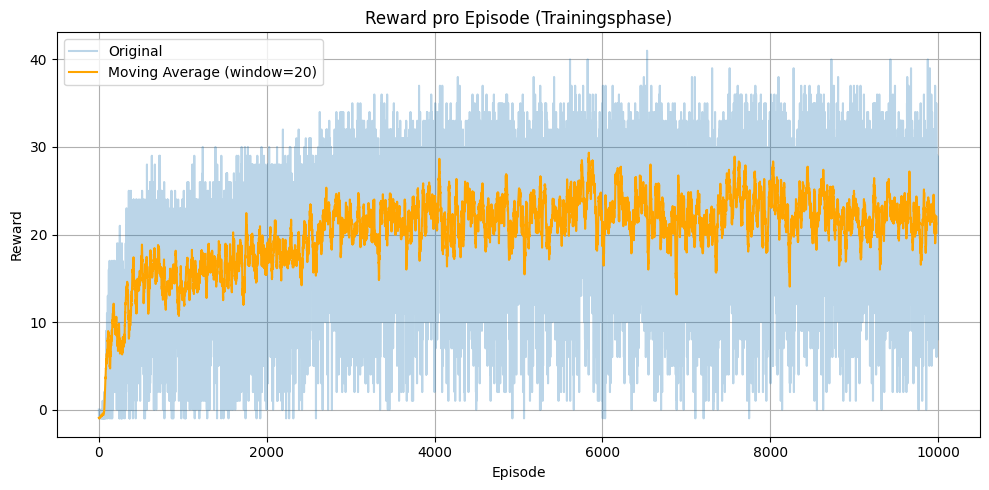


Starte Evaluation des trainierten Agenten...


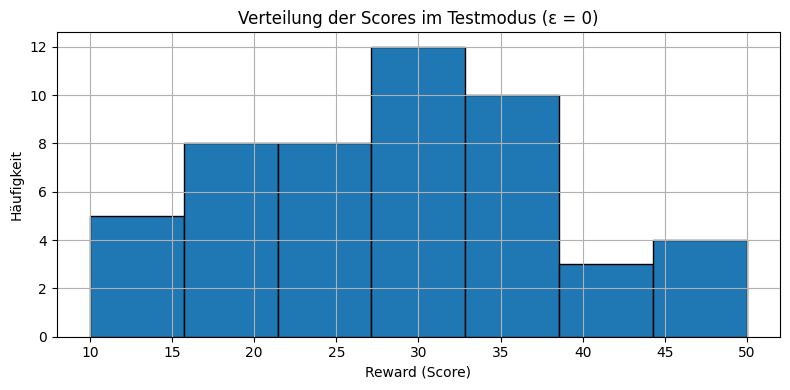

Durchschnittlicher Score über 50 Testspiele: 28.78
Maximaler Score im Test: 50


In [4]:
# ----------------------
# Parameter für Training & Auswertung
# ----------------------
EPISODES = 10000            # Anzahl der Trainingsdurchläufe
MAX_STEPS = 500             # Max. Schritte pro Episode (Abbruchbedingung)
NUM_EVAL_EPISODES = 50      # Anzahl der Testdurchläufe nach dem Training
MOVING_AVG_WINDOW = 20      # Fenstergröße für gleitenden Durchschnitt

# ----------------------
# Initialisierung von Umgebung und Agent
# ----------------------
env = SnakeGame()
agent = QLearningAgent(actions=[0, 1, 2])  # 3 mögliche Richtungsaktionen

scores = []  # Speichert die Rewards pro Trainings-Episode

# ----------------------
# Training des Q-Learning-Agenten
# ----------------------
print("Starte Training...\n")

for episode in trange(EPISODES, desc="Training"):
    state = env.reset()
    total_reward = 0

    for _ in range(MAX_STEPS):
        # Aktion wählen (ε-greedy)
        action = agent.choose_action(state)

        # Aktion ausführen, neuen Zustand und Belohnung erhalten
        next_state, reward, done, _ = env.step(action)

        # Q-Tabelle aktualisieren
        agent.update(state, action, reward, next_state, done)

        # Zustand aktualisieren
        state = next_state
        total_reward += reward

        if done:
            break

    scores.append(total_reward)  # Reward dieser Episode speichern

# ----------------------
# Gleitenden Durchschnitt berechnen
# ----------------------
def moving_average(data, window=MOVING_AVG_WINDOW):
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothed_scores = moving_average(scores)

# ----------------------
# Plot: Trainingsverlauf (Rewards pro Episode)
# ----------------------
plt.figure(figsize=(10, 5))
plt.plot(scores, alpha=0.3, label="Original")
plt.plot(range(len(smoothed_scores)), smoothed_scores, color='orange', label=f"Moving Average (window={MOVING_AVG_WINDOW})")
plt.title("Reward pro Episode (Trainingsphase)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------
# Evaluation des trainierten Agenten
# ----------------------
print("\nStarte Evaluation des trainierten Agenten...")

agent.epsilon = 0  # Deaktiviert Exploration: rein deterministische Entscheidungen

eval_scores = []

for _ in range(NUM_EVAL_EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward

    eval_scores.append(total_reward)

# ----------------------
# Plot: Score-Histogramm nach Evaluation
# ----------------------
plt.figure(figsize=(8, 4))
plt.hist(eval_scores, bins='auto', edgecolor='black')
plt.title("Verteilung der Scores im Testmodus (ε = 0)")
plt.xlabel("Reward (Score)")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ergebnis
print(f"Durchschnittlicher Score über {NUM_EVAL_EPISODES} Testspiele: {np.mean(eval_scores):.2f}")
print(f"Maximaler Score im Test: {np.max(eval_scores)}")

## 💾 Modell speichern
Die Q-Tabelle wird als `.pkl` gespeichert, um sie später erneut zu laden.

In [5]:
agent.save("q_table.pkl")
print("Q-Tabelle gespeichert ✅")

Q-Tabelle gespeichert ✅


## 🎮 Live-Demo: Trainierter Agent spielt Snake
Hier beobachtest du den Agenten in Aktion.

In [ ]:
# Umgebung und Agent initialisieren
env = SnakeGame()
agent = QLearningAgent(actions=[0, 1, 2])

# Bereits trainierte Q-Tabelle laden
agent.load("q_table.pkl")

# ε = 0 → es wird ausschließlich die beste bekannte Aktion gewählt
agent.epsilon = 0

NUM_GAMES = 1  # Anzahl der anzuzeigenden Spiele

# Live-Demonstration mehrerer Spiele
for i in range(1, NUM_GAMES + 1):
    state = env.reset()
    done = False
    score = 0

    print(f"\n🎮 Starte Spiel {i}...")

    while not done:
        # Beste Aktion basierend auf Q-Werten wählen
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        score += reward

        # Spiel anzeigen
        env.render()

        # Zeitverzögerung für bessere Sichtbarkeit
        time.sleep(0.1)

    print(f"🏁 Spiel {i} beendet. Score: {score}")
    time.sleep(1)  # kurze Pause zwischen Spielen


🎮 Starte Spiel 1...
🏁 Spiel 1 beendet. Score: 32


: 